# Mining the _de novo_ transcriptomes to improve genome annotation

An ISO-seq transcriptome and two rounds of BRAKER3 have produced close to 14,500 gene models for the
_P. litorale_ genome. However, manual inspection of the RNA-seq peaks in the genome browser revealed
that there are still plenty of loci with plausible gene locations that did not receive a gene model.

To alleviate that I will try to use the _de novo_ transcriptomes that were generated from the same 
RNA-seq data that was used for the genome annotation. The idea is to map onto the draft genome and 
keep the transcripts that don't overlap with any gene models, then gather evidence from multiple
transcriptomes to generate gene models.

In [1]:
%%bash
cd /Volumes/scratch/pycnogonum/genome/draft/annot_merge/
cat isoseq.gff > merged.gff3
cat braker.gff >> merged.gff3
cat braker2_unique_renamed_nocodon_intron.gff3 >> merged.gff3

cd /Volumes/scratch/pycnogonum/genome/draft/annot_merge/denovo_txomes
DRAFT=/Volumes/scratch/pycnogonum/genome/draft/annot_merge/merged.gff3
BASE=/Volumes/scratch/pycnogonum/genome/draft/transcriptome

EMBRYO3=$BASE/EMBRYO3/txome_assembly.gff
INSTAR1=$BASE/INSTAR1/txome_assembly.gff
INSTAR2=$BASE/INSTAR2/txome_assembly.gff
INSTAR3=$BASE/INSTAR3/txome_assembly.gff
INSTAR4=$BASE/INSTAR4/txome_assembly.gff
INSTAR5=$BASE/INSTAR5/txome_assembly.gff
INSTAR6=$BASE/INSTAR6/txome_assembly.gff
JUV1=$BASE/JUV1/txome_assembly.gff
SUBADULT=$BASE/SUBADULT/txome_assembly.gff

bedtools intersect -v -a $EMBRYO3 -b $DRAFT | sed s/TRINITY/EMBRYO3/g > EMBRYO3.gff
bedtools intersect -v -a $INSTAR1 -b $DRAFT | sed s/TRINITY/INSTAR1/g > INSTAR1.gff
bedtools intersect -v -a $INSTAR2 -b $DRAFT | sed s/TRINITY/INSTAR2/g > INSTAR2.gff
bedtools intersect -v -a $INSTAR3 -b $DRAFT | sed s/TRINITY/INSTAR3/g > INSTAR3.gff
bedtools intersect -v -a $INSTAR4 -b $DRAFT | sed s/TRINITY/INSTAR4/g > INSTAR4.gff
bedtools intersect -v -a $INSTAR5 -b $DRAFT | sed s/TRINITY/INSTAR5/g > INSTAR5.gff
bedtools intersect -v -a $INSTAR6 -b $DRAFT | sed s/TRINITY/INSTAR6/g > INSTAR6.gff
bedtools intersect -v -a $JUV1 -b $DRAFT | sed s/TRINITY/JUV1/g > JUV1.gff
bedtools intersect -v -a $SUBADULT -b $DRAFT | sed s/TRINITY/SUBADULT/g > SUBADULT.gff

Now we can look at the overlap of all of these GFF files, again using `bedtools intersect`. Since
this is already tenuous evidence for gene models we should be as strict as possible.

In [2]:
%%bash 
cd /Volumes/scratch/pycnogonum/genome/draft/annot_merge/denovo_txomes

bedtools intersect -f 0.9 -F 0.9 -wao -a INSTAR3.gff -b EMBRYO3.gff INSTAR1.gff INSTAR2.gff INSTAR4.gff INSTAR5.gff INSTAR6.gff JUV1.gff SUBADULT.gff > overlap.gff

In [3]:
from tqdm import tqdm 

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

In [4]:
file_order = {
    "1": "EMBRYO3",
    "2": "INSTAR1",
    "3": "INSTAR2",
    "4": "INSTAR4",
    "5": "INSTAR5",
    "6": "INSTAR6",
    "7": "JUV1",
    "8": "SUBADULT",
}

# assign the tab10 colors to each stage
colors = {
    "EMBRYO3": "tab:blue",
    "INSTAR1": "tab:orange",
    "INSTAR2": "tab:green",
    "INSTAR4": "tab:red",
    "INSTAR5": "tab:purple",
    "INSTAR6": "tab:brown",
    "JUV1": "tab:pink",
    "SUBADULT": "tab:gray",
}

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='EMBRYO3', markerfacecolor='tab:blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='INSTAR1', markerfacecolor='tab:orange', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='INSTAR2', markerfacecolor='tab:green', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='INSTAR4', markerfacecolor='tab:red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='INSTAR5', markerfacecolor='tab:purple', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='INSTAR6', markerfacecolor='tab:brown', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='JUV1', markerfacecolor='tab:pink', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='SUBADULT', markerfacecolor='tab:gray', markersize=8),
]

In [5]:
overlap = pd.read_csv('/Volumes/scratch/pycnogonum/genome/draft/annot_merge/denovo_txomes/overlap.gff', sep='\t', header=None)
overlap = overlap.drop(columns=[1, 11])
overlap["instar3_match"] = overlap[8].str.split(';').str[0].str.split('=').str[1].str.split(".").str[0]
overlap["target_match"] = overlap[18].str.split(';').str[0].str.split('=').str[1].str.split(".").str[0]
overlap["target_dataset"] = overlap[9].astype(str).replace(file_order)
overlap["target_id"] = overlap["target_dataset"].astype(str) + "_" + overlap["target_match"].astype(str)
# we should only keep lines that match similar things (cDNA_match or cDNA_match_part)
keep = overlap[2] == overlap[12]
overlap = overlap[keep]

/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/ipykernel_61764/3506524708.py:1: DtypeWarning: Columns (9,15) have mixed types. Specify dtype option on import or set low_memory=False.
  overlap = pd.read_csv('/Volumes/scratch/pycnogonum/genome/draft/annot_merge/denovo_txomes/overlap.gff', sep='\t', header=None)


In [6]:
overlap.shape

(2635957, 22)

In [7]:
gene_level_matches = overlap[overlap[2] == 'cDNA_match']['instar3_match'].unique()
overlap = overlap[overlap["instar3_match"].isin(gene_level_matches)]

In [8]:
overlap.shape

(531784, 22)

In [9]:
overview = overlap[overlap[2] == "cDNA_match"].groupby("instar3_match").apply(lambda x: x["target_dataset"].value_counts()>0, include_groups=False).unstack()
overview["total_score"] = overview.sum(axis=1)

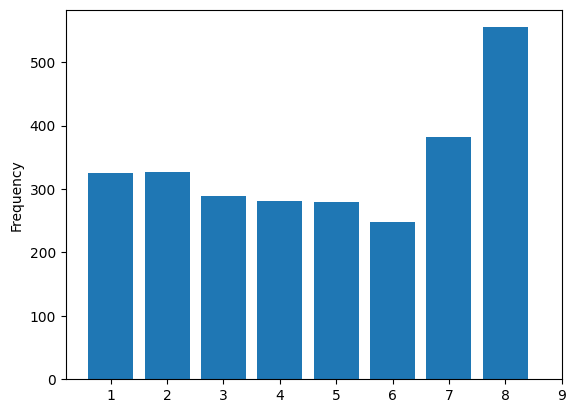

In [10]:
overview["total_score"].plot(kind='hist', bins=np.arange(9)+0.6, color='tab:blue', width=0.8);

In [11]:
def find_gene_boundaries(df):
    entire = df[df[2] == "cDNA_match"]
    if entire.shape[0] == 0:
        return None
    start = entire[3].unique()
    end = entire[4].unique()
    if len(start) > 1 or len(end) > 1:
        return ValueError("More than one start or end")
    return (df[0].iloc[0], start[0], end[0])

In [12]:
def find_exon_boundaries(df):
    start = df[13].value_counts().idxmax()
    end = df[14].value_counts().idxmax()
    return (start, end)

In [13]:
def gene_string(gene_id, start, stop, seqid, source, strand, support):
    seq_type = "gene"
    score = "."
    phase = "."
    attributes = f"ID={gene_id};gene_id={gene_id};support={support}"
    string = f"{seqid}\t{source}\t{seq_type}\t{start}\t{stop}\t{score}\t{strand}\t{phase}\t{attributes};\n"
    return string

def transcript_string(gene_id, transcript_id, seqid, source, start, stop, score, strand):
    seq_type = "mRNA"
    phase = "."
    attributes = f"ID={transcript_id};Parent={gene_id}"
    string = f"{seqid}\t{source}\t{seq_type}\t{start}\t{stop}\t{score}\t{strand}\t{phase}\t{attributes};\n"
    return string

def exon_string(transcript_id, exon_counter, seqid, source, start, stop, score, strand):
    seq_type = "exon"
    phase = "."
    attributes = f"ID={transcript_id}.exon{exon_counter};Parent={transcript_id}"
    exon_string = f"{seqid}\t{source}\t{seq_type}\t{start}\t{stop}\t{score}\t{strand}\t{phase}\t{attributes};\n"
    
    seq_type = "CDS"
    phase="0"
    attributes = f"ID={transcript_id}.CDS{exon_counter};Parent={transcript_id}"
    CDS_string = f"{seqid}\t{source}\t{seq_type}\t{start}\t{stop}\t{score}\t{strand}\t{phase}\t{attributes};\n"
    
    return exon_string + CDS_string

def contained(gene, catalogue):
    scaffold, start, stop = gene
    for seen in catalogue:
        if scaffold != seen[0]:
            continue
        if start >= seen[1] and stop <= seen[2]:
            return True
        if start == seen[1] or stop == seen[2]:
            return True
    return False

In [14]:
# test = overlap[overlap["instar3_match"] == "match262"]
problematic = []
seen = []

with open("/Volumes/scratch/pycnogonum/genome/draft/annot_merge/denovo_txomes/overlap_translated.gff3", "w") as gff:
    for i, match in enumerate(tqdm(gene_level_matches)):
        gene = overlap[overlap["instar3_match"] == match]
        pseudochrom, start, stop = find_gene_boundaries(gene)
        if contained([pseudochrom, start, stop], seen):
            continue
        seen.append([pseudochrom, start, stop])
        parts = gene[gene[2] == "cDNA_match_part"].copy()
        if parts.shape[0] == 0:
            problematic.append(match)
            continue
        parts["boundary"] = parts[3].astype(str) + "-" + parts[4].astype(str)
        exons = parts.groupby("boundary").apply(lambda x: find_exon_boundaries(x), include_groups=False)

        seqid = gene[0].values[0]
        gene_id = f"at_DN{i+1:04d}"
        source = "Trinity"
        strand = gene[6].values[0]
        support = len(gene["target_dataset"].unique())
        gene_gff = gene_string(gene_id, start, stop, seqid, source, strand, support)
        gff.write(gene_gff)
        transcript_gff = transcript_string(gene_id, gene_id+".t1", seqid, source, start, stop, ".", strand)
        gff.write(transcript_gff)
        for exon in exons:
            exon_gff = exon_string(gene_id + ".t1", i, seqid, source, exon[0], exon[1], ".", strand)
            gff.write(exon_gff)

100%|██████████| 2686/2686 [02:12<00:00, 20.34it/s]


In [15]:
problematic

['match20947',
 'match31308',
 'match31516',
 'match31653',
 'match32973',
 'match36716']

In [16]:
len(seen)

780